Pruebas sobre el dataset 

In [285]:
%pip install rapidfuzz --quiet
%pip install spacy --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [92]:
%pip install wordcloud matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


### Librerías

In [239]:
import pandas as pd
import spacy
from collections import defaultdict
from pprint import pprint
import re
from unidecode import unidecode
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np


In [289]:
!python -m spacy download es_core_news_md --quiet


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


# Cargar Corpus y formatear fechas

In [3]:
file_path = r"C:\Users\karen\Documents\HumanidadesDigitales_git\BDD_Corpus\Corpus_completo_revisado.xlsx"
corpus_completo = pd.read_excel(file_path)


In [4]:
# Formatear fechas

meses = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

def convertir_fecha(fecha_str):
    partes = fecha_str.split(' de ')
    dia = partes[0].zfill(2)  # Asegura 2 dígitos para días 1-9
    mes = meses[partes[1]]
    año = partes[2]
    return f"{dia}/{mes}/{año}"  # Formato DD/MM/AAAA

corpus_completo['Fecha'] = corpus_completo['Fecha'].apply(convertir_fecha)
corpus_completo['Fecha'] = pd.to_datetime(corpus_completo['Fecha'], format='%d/%m/%Y', errors='coerce')

In [5]:
corpus_completo.head()

,Diario,Autor,Fecha,Título,Texto,Vínculo,ID
0,El Espectador,Gonzalo Hernández,2018-01-01,Fajardo: para nada tibio,"La Coalición Colombia –Partido Alianza Verde, ...",https://web.archive.org/web/20180102104221/htt...,1
1,El Espectador,Eduardo Barajas Sandoval,2018-01-01,Macedonia de Norte,Las interpretaciones de la historia sirven com...,https://web.archive.org/web/20180102104221/htt...,2
2,El Espectador,Daniel Emilio Rojas Castro,2018-01-01,El nacionalismo según Vargas Llosa,La semana pasada Mario Vargas Llosa publicó un...,https://web.archive.org/web/20180102104221/htt...,3
3,El Espectador,Reinaldo Spitaletta,2018-01-01,"Tiempo sagrado, tiempo profano","Pudiera decirse, sin ser una verdad absoluta, ...",https://web.archive.org/web/20180102104221/htt...,4
4,El Espectador,Aura Lucía Mera,2018-01-01,La rebelión de los bueyes,Lo mejor del encierro de Las Ventas fueron los...,https://web.archive.org/web/20180102104221/htt...,5


# Búsqueda exacta de  tesauros

In [6]:
textos = corpus_completo['Texto'].tolist()


In [7]:
nlp = spacy.load("es_core_news_md")

In [8]:
nlp.Defaults.stop_words |= {"tola","maruja","gazapera", "email protected"}

In [9]:
def preprocesar_texto(texto):
    # Limpieza
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE) # eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    
    # Procesamiento con spaCy tokenizacion
    doc = nlp(texto)
    
    # Lematización y filtrado
    tokens = [
        token.text for token in doc
        if not token.is_punct 
        and not token.is_stop
        and not token.is_space
        #and token.pos_ in ['NOUN', 'VERB', 'PROPN','ADJ', 'NUM']  # Tomar solo sustantivos, verbos, nombres propios, adjetivos y numerales
        and token.text.isalpha()  # Solo palabras alfabéticas
    ]
    
    return " ".join(tokens)
    

In [74]:
def limpieza(texto):

    
    texto = str(texto.lower())
    texto = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', texto)
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)  # Eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    texto = ''.join(c if c in 'ñÑ' else unicodedata.normalize('NFD', c)[0] for c in texto)
    #texto = texto.encode('ascii', 'ignore').decode('ascii')  # Solo ASCII
    texto = re.sub(r'\s+', ' ', texto).strip()  # Normalizar espacios
    
    return texto

textos_unicode = [limpieza(texto) for texto in textos]

In [161]:
diccionario_ciencia = ["cientific", "ciencia", "tecnologia", "experimento", "laboratorio"]
diccionario_ciencia = [limpieza(term) for term in diccionario_ciencia]
patron_busqueda = re.compile(r"\b(" + "|".join(diccionario_ciencia) + r")", flags=re.IGNORECASE)

diccionario_ciencia


['cientific', 'ciencia', 'tecnologia', 'experimento', 'laboratorio']

In [162]:
def busqueda_palabras(textos, palabras_busqueda, ventana=5, ventana_stopwords=10):
    patron = re.compile(r"\b(" + "|".join(palabras_busqueda) + r")", re.IGNORECASE)
    resultados = []
    
    # Inicialmente pregunta si el texto contiene alguna palabra de búsqueda
    for i, texto in enumerate(textos):
        palabras_original = texto.split()

        # Buscar en texto (rápido)
        if patron.search(texto):
            # Buscar posiciones exactas en original
            for match in patron.finditer(texto):
                inicio, fin = match.span()
                
                # Convertir posición de caracteres a índice de palabra
                palabras_antes = texto[:inicio].split() # contar palabras antes de la coincidencia 
                palabra_idx = len(palabras_antes) - 1 if palabras_antes else 0
                
                contexto = " ".join(palabras_original[max(0, palabra_idx-ventana):min(palabra_idx+ventana+1, len(palabras_original)+1)])

                antes_sin_stopwords = [word for word in palabras_antes if (word.lower() not in STOP_WORDS)]
                antes_sin_stopwords = list(set(antes_sin_stopwords[-ventana_stopwords:]))  # limitar a ventana de stopwords
                despues_sin_stopwords = [word for word in palabras_original[palabra_idx+1:len(palabras_original)+1] if (word.lower() not in STOP_WORDS)]
                despues_sin_stopwords = list(set(despues_sin_stopwords[:ventana_stopwords]))  # limitar a ventana de stopwords
                
                resultados.append({
                    'texto_index': i,
                    'palabra': match.group(),
                    'posicion_caracter': (inicio, fin),
                    'posicion_palabra': palabra_idx,
                    'contexto': contexto,
                    'Antes_sin_stopwords': antes_sin_stopwords,
                    'Despues_sin_stopwords': despues_sin_stopwords,
                    'metadata': corpus_completo.iloc[i][['Título', 'Autor', 'Fecha', 'ID', 'Diario']].to_dict()
                })
    resultados_df = pd.DataFrame(resultados)

    return resultados_df

In [163]:
resultados = busqueda_palabras(textos_unicode, diccionario_ciencia, 10,10)
len(resultados)


4836

In [164]:
pprint(resultados.iloc[7].metadata)
pprint(resultados.iloc[7].contexto)
pprint(resultados.iloc[7])

{'Autor': 'Mauricio Rubio',
 'Diario': 'El Espectador',
 'Fecha': Timestamp('2018-01-24 00:00:00'),
 'ID': 36,
 'Título': 'Celos y peleas domésticas'}
('el nivel de tolerancia con los sinverguenzas se redujo las nuevas '
 'tecnologias que facilitan infidelidades son tambien un arma de doble')
texto_index                                                             35
palabra                                                         tecnologia
posicion_caracter                                             (3580, 3590)
posicion_palabra                                                       614
contexto                 el nivel de tolerancia con los sinverguenzas s...
Antes_sin_stopwords      [conocen, tolerancia, laboral, nivel, lopez, m...
Despues_sin_stopwords    [facilitan, aventuras, seguimiento, extramarit...
metadata                 {'Título': 'Celos y peleas domésticas', 'Autor...
Name: 7, dtype: object


In [165]:
todas_las_palabras = []
for lista in resultados['Antes_sin_stopwords']:
    todas_las_palabras.extend(lista)

for lista in resultados['Despues_sin_stopwords']:
    todas_las_palabras.extend(lista)

palabras_contexto = ' '.join(todas_las_palabras)

In [166]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(palabras_contexto)

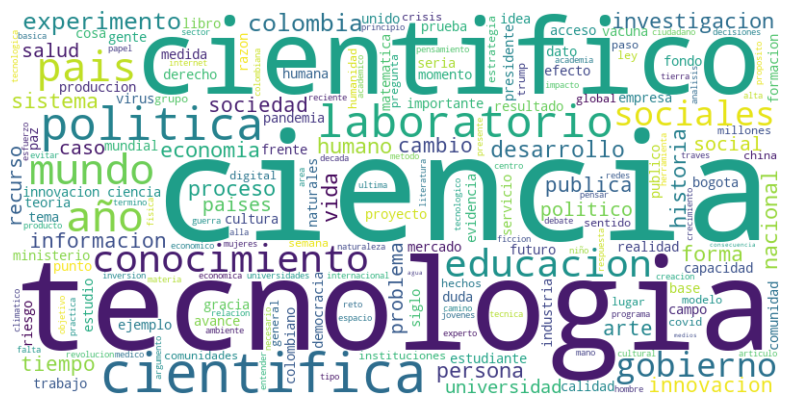

In [167]:
plt.figure(figsize=(10, 5)) # Ajusta el tamaño de la figura
plt.imshow(wordcloud, interpolation='bilinear') # Muestra la imagen de la nube de palabras
plt.axis('off') # Elimina los ejes
plt.show()

In [168]:
word_counter = Counter(palabras_contexto.split())
word_counter.most_common(50)

[('ciencia', 1694),
 ('tecnologia', 1432),
 ('cientificos', 521),
 ('ciencias', 476),
 ('cientifico', 434),
 ('cientifica', 420),
 ('tecnologias', 396),
 ('pais', 350),
 ('educacion', 349),
 ('mundo', 339),
 ('innovacion', 335),
 ('colombia', 311),
 ('sociales', 305),
 ('politica', 305),
 ('conocimiento', 282),
 ('desarrollo', 275),
 ('años', 269),
 ('nacional', 244),
 ('investigacion', 224),
 ('laboratorio', 214),
 ('gobierno', 204),
 ('economia', 194),
 ('universidad', 193),
 ('historia', 191),
 ('social', 182),
 ('experimento', 180),
 ('informacion', 175),
 ('laboratorios', 172),
 ('personas', 165),
 ('cientificas', 163),
 ('paises', 162),
 ('vida', 157),
 ('sistema', 151),
 ('salud', 148),
 ('sociedad', 147),
 ('forma', 140),
 ('recursos', 136),
 ('cambio', 134),
 ('cultura', 133),
 ('ejemplo', 129),
 ('politicas', 121),
 ('proceso', 118),
 ('tiempo', 115),
 ('arte', 109),
 ('trabajo', 109),
 ('capacidad', 105),
 ('importante', 105),
 ('ministerio', 102),
 ('evidencia', 102),
 ('pr

# Búsqueda semántica de tesauros

In [222]:
def obtener_original(id, corpus):
    return corpus[corpus['ID'] == id]

In [312]:
# Dividir texto en párrafos

# Lista para almacenar los resultados
parrafos = []

# Iterar sobre cada fila del dataframe
for idx, row in corpus_completo.iterrows():
    texto = row['Texto']
    id_corpus = row['ID']  
    nombre = row['Título']
    
    if pd.notnull(texto):
        segmentos = texto.split('\n')
        for segmento in segmentos:
            if segmento.strip() and len(segmento) > 40:  # Solo agregar segmentos no vacíos
                parrafos.append({
                    'ID_corpus': id_corpus,
                    'texto_segmentado': segmento.strip(),
                    'titulo': nombre,
                    'autor' : row['Autor'],
                    'fecha' : row['Fecha'],
                    'indice_original': idx
                })

# Crear el nuevo dataframe
tabla_parrafos = pd.DataFrame(parrafos)

In [313]:
tabla_parrafos

,ID_corpus,texto_segmentado,titulo,autor,fecha,indice_original
0,1,"La Coalición Colombia –Partido Alianza Verde, ...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
1,1,Fajardo diagnostica a Colombia como un país fr...,Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
2,1,"Promete un liderazgo hacia la reconciliación, ...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
3,1,La energía y el énfasis de sus presentaciones ...,Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
4,1,"Esto no debe, sin embargo, generar confusiones...",Fajardo: para nada tibio,Gonzalo Hernández,2018-01-01,0
...,...,...,...,...,...,...
109377,13337,"Sin embargo, la solicitud de anexión fue recha...",Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109378,13337,El secretario del congreso venezolano fue Sant...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109379,13337,Las condiciones del congreso venezolano para r...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336
109380,13337,Aunque Colombia todavía no estaba consagrada a...,Casanare y el bicentenario,Julio Londoño Paredes,2018-12-28,13336


In [314]:
# Generar embeddings de textos
#modelo_embedding = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
modelo_embedding = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [315]:
texto_segmentado_list = tabla_parrafos['texto_segmentado'].astype(str).tolist()[:2000]

In [316]:
embeddings = modelo_embedding.encode(texto_segmentado_list, convert_to_tensor=False).astype('float32')

In [317]:
indice = faiss.IndexFlatL2(embeddings.shape[1])
indice.add(embeddings)

In [296]:
diccionario_ciencia

['cientific', 'ciencia', 'tecnologia', 'experimento', 'laboratorio']

In [318]:
# Buscar texto similar a una consulta 
resultados_busqueda_semantica = []
for w in diccionario_ciencia:
    consulta = w
    embedding_consulta = modelo_embedding.encode(consulta, convert_to_tensor=False).astype('float32')
    embedding_consulta = np.array([embedding_consulta])  # FAISS espera una matriz 2D
    distancias, indices = indice.search(embedding_consulta, k = 2000)
    percentile = np.percentile(distancias[0],70)
    for i, d in enumerate(distancias[0]):
        if d > percentile:
            resultados_busqueda_semantica.append(
                {
                    'consulta': w,
                    'texto_segmentado': texto_segmentado_list[indices[0][i]],
                    'distancia': d,
                    'ID_corpus': tabla_parrafos.iloc[indices[0][i]]['ID_corpus'],
                    'metadata': tabla_parrafos.iloc[indices[0][i]][['ID_corpus', 'titulo', 'autor', 'fecha', 'indice_original']].to_dict()
                }
            )
resultados_busqueda_semantica_df = pd.DataFrame(resultados_busqueda_semantica)

In [319]:
resultados_busqueda_semantica_df

,consulta,texto_segmentado,distancia,ID_corpus,metadata
0,cientific,3- Parquea el carro precisamente enfrente del ...,12.866076,243,"{'ID_corpus': 243, 'titulo': '¡Ay! qué orgullo..."
1,cientific,Desde antes de que Trump fuera elegido se cono...,12.867590,138,"{'ID_corpus': 138, 'titulo': 'Un racista en la..."
2,cientific,Hacía muchísimo calor. No porque fuera el mes ...,12.871696,154,"{'ID_corpus': 154, 'titulo': 'Maldita costumbr..."
3,cientific,En democracia la solución al dilema no parece ...,12.872915,95,"{'ID_corpus': 95, 'titulo': 'Perú: dilemas com..."
4,cientific,"Dos mil diecisiete fue pues, el año del odio. ...",12.875763,7,"{'ID_corpus': 7, 'titulo': '2017 (I)', 'autor'..."
...,...,...,...,...,...
2995,laboratorio,-Israel demanda a Palestina por abuso de confi...,14.278656,58,"{'ID_corpus': 58, 'titulo': 'Tola y Maruja hac..."
2996,laboratorio,"Ciertamente, como diría alguien, ser colombian...",14.613642,243,"{'ID_corpus': 243, 'titulo': '¡Ay! qué orgullo..."
2997,laboratorio,"Por otro lado, la Turquía Otomana, a nombre de...",14.747519,224,"{'ID_corpus': 224, 'titulo': 'Entre la fe y la..."
2998,laboratorio,"Vayamos primero con Mehmed II, quien en 1453 t...",15.025013,224,"{'ID_corpus': 224, 'titulo': 'Entre la fe y la..."


In [320]:
resultados_busqueda_semantica_df.groupby('consulta').size()

consulta
ciencia        600
cientific      600
experimento    600
laboratorio    600
tecnologia     600
dtype: int64

In [321]:
resultados_busqueda_semantica_df[resultados_busqueda_semantica_df['ID_corpus'] == 12]

,consulta,texto_segmentado,distancia,ID_corpus,metadata
232,cientific,Permítanme ahora remitirme al sobrino de la ví...,13.396679,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
444,cientific,http://jorgegomezpinilla. blogspot.com.co,14.213885,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
945,ciencia,Permítanme ahora remitirme al sobrino de la ví...,9.911924,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1070,ciencia,http://jorgegomezpinilla. blogspot.com.co,10.375779,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1331,tecnologia,Ese día los oyentes despertaron escandalizados...,12.606810,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1364,tecnologia,"Ya para concluir, está lo que le pregunté a Ma...",12.716633,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1376,tecnologia,De otro lado: ¿cuál equilibrio puede haber e...,12.749008,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1616,tecnologia,http://jorgegomezpinilla. blogspot.com.co,13.472363,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1617,tecnologia,A tan aberrante paradoja intenté darle explica...,13.476939,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."
1684,tecnologia,Permítanme ahora remitirme al sobrino de la ví...,13.850063,12,"{'ID_corpus': 12, 'titulo': 'Julio Sánchez y M..."


In [322]:
pprint(len(resultados_busqueda_semantica_df.iloc[416].texto_segmentado))

476
